In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    override_params={
        'save_dir': '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode'
    }
)
assert len(gf.queue.remaining_genes) == 0

In [6]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

In [7]:
interactions = {}

for ct in adata.obs.cell_type.unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

In [19]:
interactions['Th2'].query('gene=="Il2ra"').groupby('interaction').sum().sort_values(
    by='beta', ascending=False).head(10)

,gene,beta,interaction_type
interaction,,,
beta_C3$Itgb2,Il2ra,0.003608,ligand-receptor
beta_Ccl5$Ccr4,Il2ra,0.001757,ligand-receptor
beta_Ccl22$Ccr4,Il2ra,0.001535,ligand-receptor
beta_Mdk$Ncl,Il2ra,0.000748,ligand-receptor
beta_Il2$Il2rb,Il2ra,0.000439,ligand-receptor
beta_C3$Itgam,Il2ra,0.000243,ligand-receptor
beta_Cxcl13$Cxcr3,Il2ra,0.000228,ligand-receptor
beta_Nampt$Itgb1,Il2ra,0.000141,ligand-receptor
beta_Ccl17$Ccr4,Il2ra,0.000137,ligand-receptor


In [89]:
dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)
    
dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')

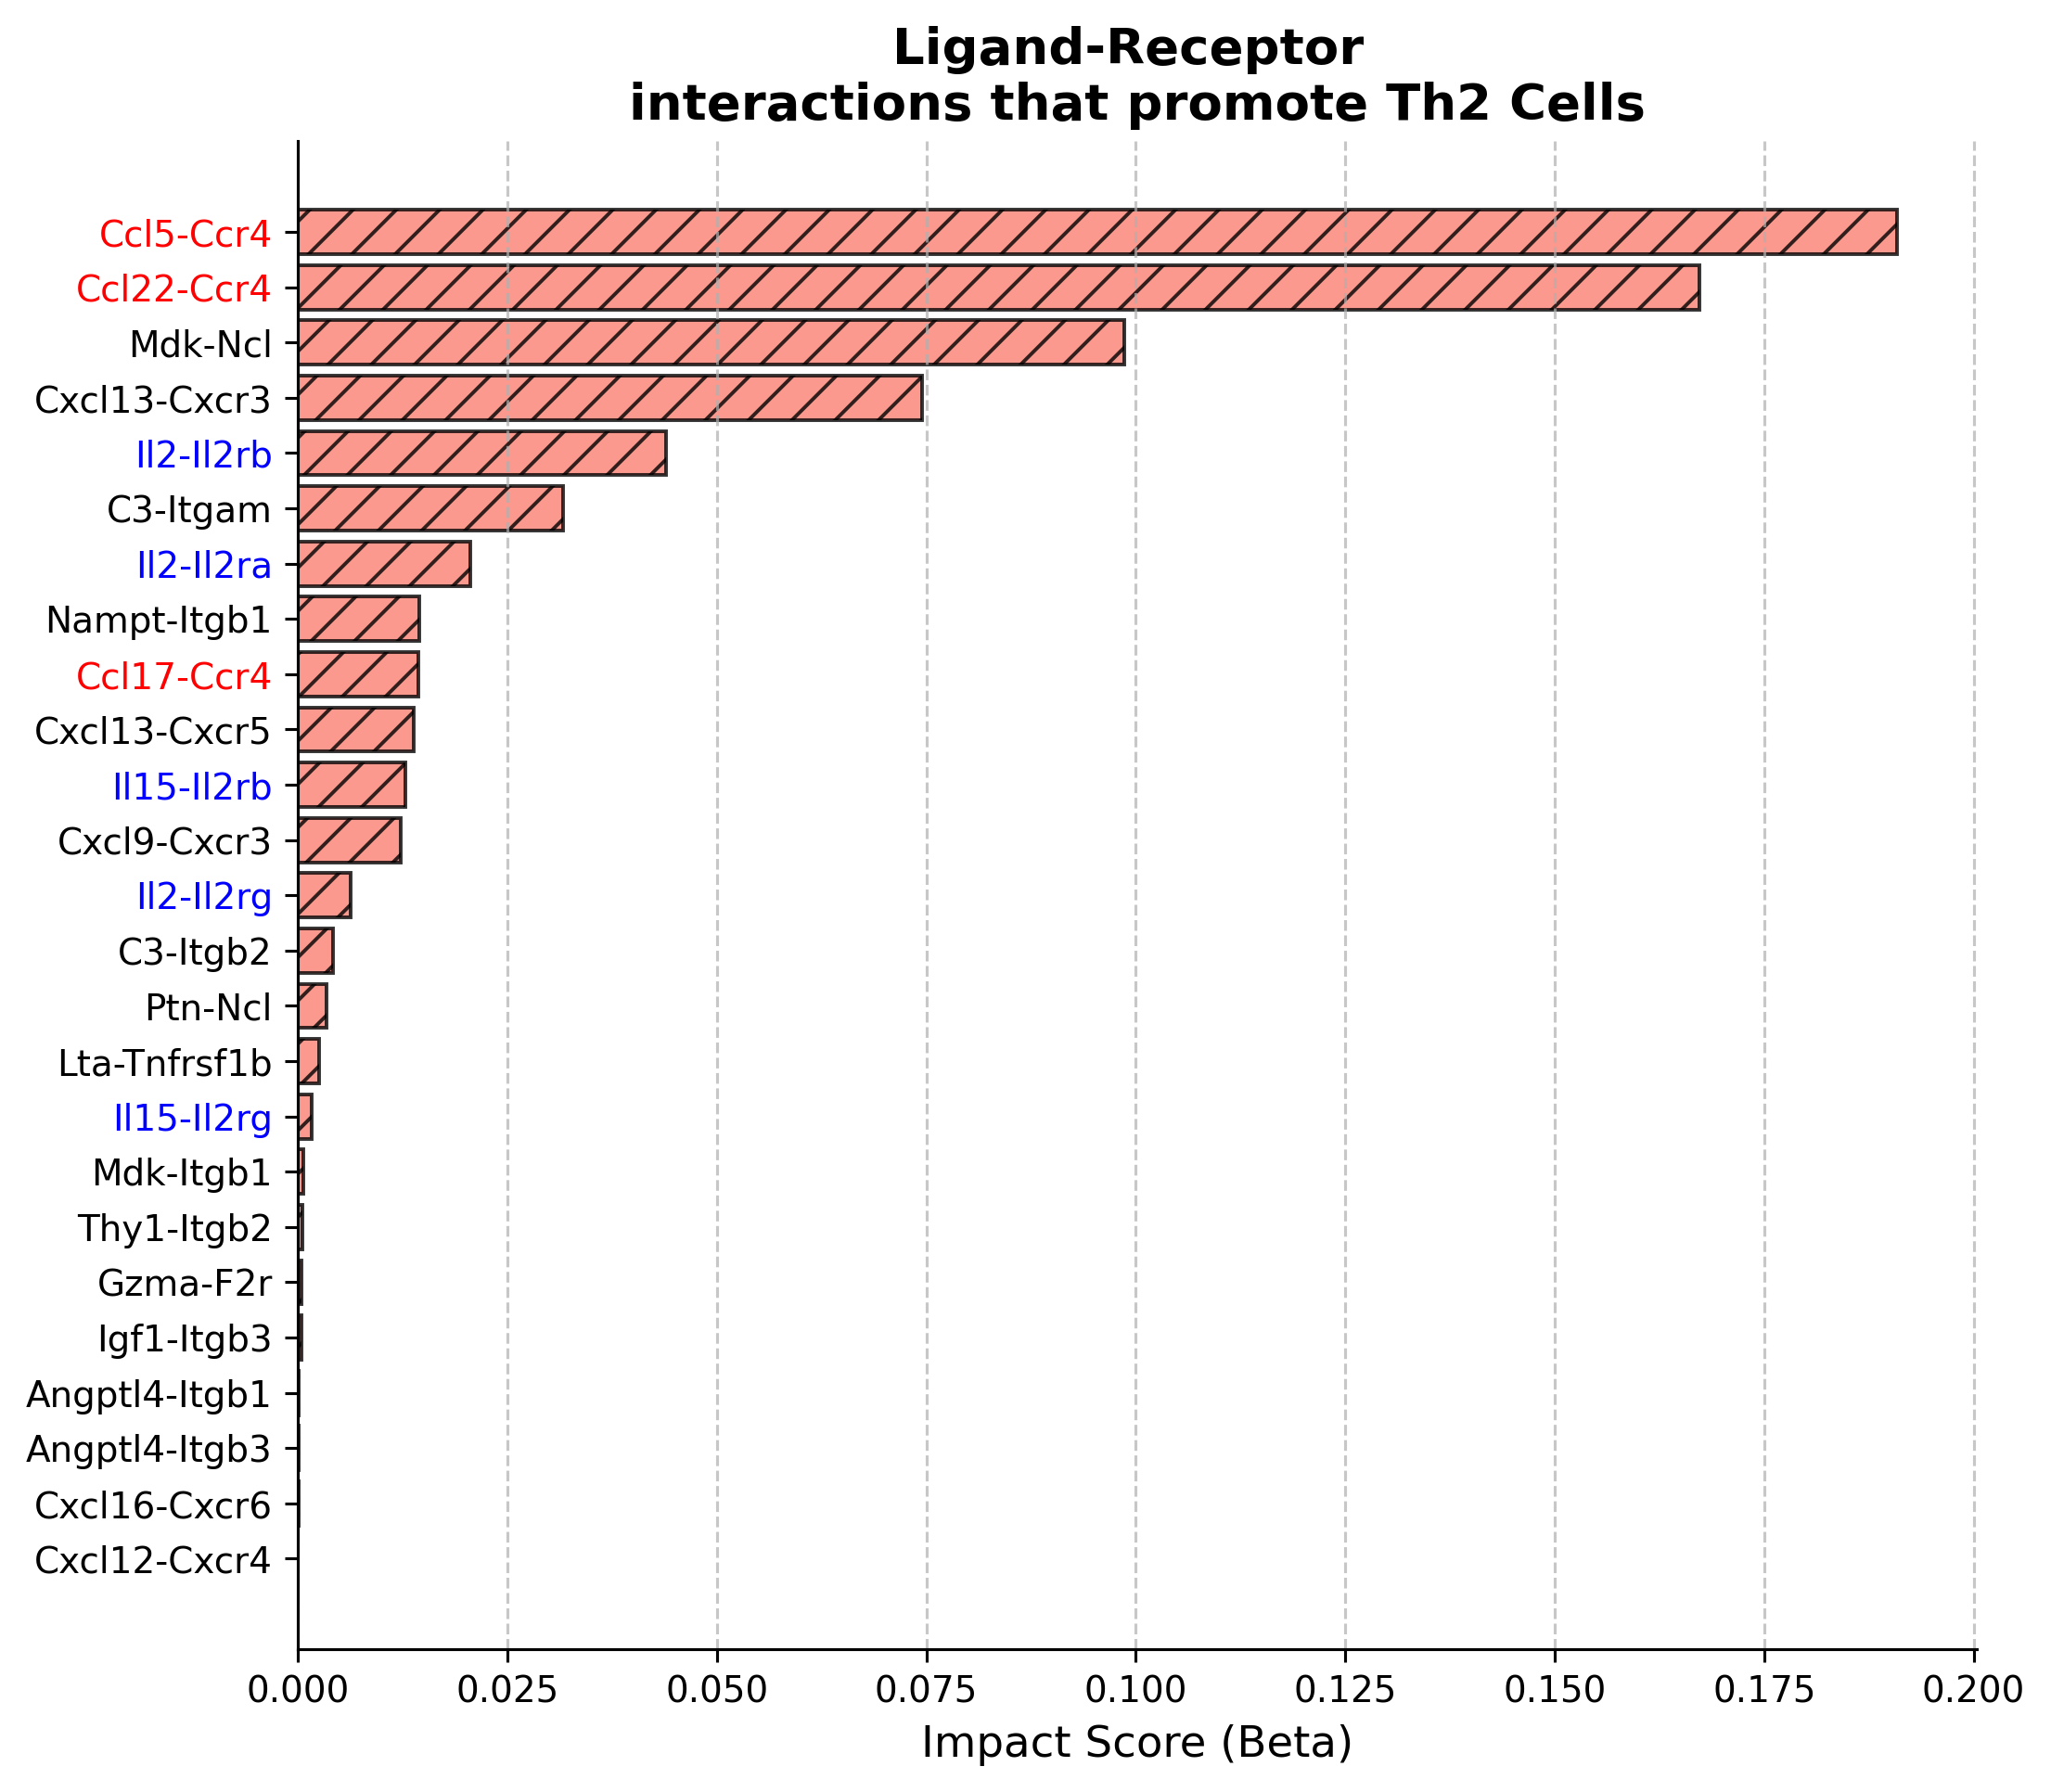

In [91]:
top_interactions = dfr.sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Th2 Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()